### Setup

The cell below downloads the code from Github and install necessary dependencies.

In [1]:
# ![ -d deeprte] || git clone --depth=1 https://github.com/mazhengcn/deeprte.git
# !cd deeprte && git pull
# !pip install -qr deeprte/requirements.txt

### Import Packages

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4,5"
# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".70"

%load_ext autoreload
%autoreload 2

import jax.numpy as jnp
import numpy as np
import jax
import time
import haiku as hk
import json
import ml_collections
from test import utils
from deeprte.model.modules import DeepRTE
from deeprte.model.tf.input_pipeline import load_tf_data
from deeprte.model.data import flat_params_to_haiku

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
jax.local_devices()

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=1, process_index=0, slice_index=0)]

### Import Pre-trained model

In [4]:
# Path to the model parameters
# PARAMS_DIR = "/workspaces/deeprte/ckpts/ckpt/square_full_it_2023-04-03T12:47:33/models/latest/step_375000_2023-04-07T00:31:21"
PARAMS_DIR = "/workspaces/deeprte/rte_data/model_params"
PARAMS_NAME = "params.npz"
CONFIG_NAME = "config.json"

config_path = os.path.join(PARAMS_DIR, CONFIG_NAME)
assert os.path.exists(f"{config_path}")

param_path = os.path.join(PARAMS_DIR, PARAMS_NAME)
assert os.path.exists(f"{param_path}")

In [5]:
# load and visualize the model config
with open(config_path) as f:
    str = f.read()
    config = json.loads(str)

config = ml_collections.ConfigDict(config["experiment_kwargs"]["config"])

config.model.green_function

attenuation:
  attention:
    key_chunk_size: 128
    key_dim: 32
    num_head: 2
    output_dim: 2
    value_dim: null
  latent_dim: 128
  num_layer: 4
  output_dim: 16
scattering:
  latent_dim: 16
  num_layer: 2

In [6]:
# Load the model parameters
np_params = np.load(param_path)
params = flat_params_to_haiku(np_params)

In [7]:
# set up the model and transform it into a jax function
def forward_fn(batch):
    out = DeepRTE(config.model)(
        batch, is_training=False, compute_loss=False, compute_metrics=False
    )
    return out


forward = hk.transform(forward_fn)
# apply = jax.jit(forward.apply)

In [8]:
keys = list(params.keys())
for k in keys:
    if "attention" in k and "attention_v2" not in k:
        str = k.replace("attention", "attention_v2")
        params[str] = params[k]
        del params[k]

In [9]:
jax.tree_map(lambda x: x.shape, params)

{'deeprte/green_function/attenuation/attention_v2/key': {'b': (64,),
  'w': (2, 64)},
 'deeprte/green_function/attenuation/attention_v2/output_projection': {'b': (2,),
  'w': (64, 2)},
 'deeprte/green_function/attenuation/attention_v2/query': {'b': (64,),
  'w': (4, 64)},
 'deeprte/green_function/attenuation/attention_v2/value': {'b': (64,),
  'w': (2, 64)},
 'deeprte/green_function/attenuation/attenuation_linear': {'b': (128,),
  'w': (10, 128)},
 'deeprte/green_function/attenuation/attenuation_linear_1': {'b': (128,),
  'w': (128, 128)},
 'deeprte/green_function/attenuation/attenuation_linear_2': {'b': (128,),
  'w': (128, 128)},
 'deeprte/green_function/attenuation/output_projection': {'b': (16,),
  'w': (128, 16)},
 'deeprte/green_function/output_projection': {'w': (16, 1)},
 'deeprte/green_function/scattering_module/__layer_stack_no_per_layer/scattering_layer/linear': {'b': (2,
   16),
  'w': (2, 16, 16)}}

### Load dataset

In [10]:
# Path to the dataset
DATA_DIR = (
    "/workspaces/deeprte/rte_data/matlab/eval-data/scattering-kernel/0311"
)
DATA_NAME = "test_bc1.mat"

# slice batch by index
idx = 0

data_path = os.path.join(DATA_DIR, DATA_NAME)
assert os.path.exists(f"{data_path}")

In [11]:
# load and slice batch by index
tf_data = load_tf_data(
    DATA_DIR,
    [
        DATA_NAME,
    ],
    normalization=False,
)
features = jax.tree_map(lambda x: jnp.array(x), tf_data)
data_feature = features[0]
batch = utils.slice_batch(idx, data_feature)

# visualize shape
jax.tree_util.tree_map(lambda x: x.shape, batch)

{'boundary': (1, 1920),
 'boundary_coords': (1920, 4),
 'boundary_scattering_kernel': (1, 1920, 24),
 'boundary_weights': (1920,),
 'phase_coords': (38400, 4),
 'position_coords': (1600, 2),
 'psi_label': (1, 38400),
 'scattering_kernel': (1, 38400, 24),
 'self_scattering_kernel': (1, 24, 24),
 'sigma': (1, 1600, 2),
 'velocity_coords': (24, 2),
 'velocity_weights': (24,)}

### Evaluate

In [12]:
# set rng seed
rng = hk.PRNGSequence(42)

In [13]:
axis_dict = utils.make_collocation_axis()
batch_in_axes = {
    k: axis_dict[k] if k in axis_dict else None for k in batch.keys()
}
apply = jax.pmap(
    lambda params, inputs: forward.apply(
        params, jax.random.PRNGKey(0), inputs
    ),
    axis_name="batch",
)

In [14]:
# get psi shape
psi_shape = utils.get_psi_shape(
    DATA_DIR,
    [
        DATA_NAME,
    ],
)
normalize_rate = utils.get_normalized_rate(config)

# get psi
def get_psi(params, batch):
    ret = apply(params, batch)
    psi = ret["predicted_solution"]
    psi = psi * normalize_rate

    return psi


# print rmse
def print_rmse(dict):
    print(
        "phi rmse:",
        jnp.sqrt(
            jnp.mean((dict["phi_label"] - dict["phi_pre"]) ** 2)
            / jnp.mean(dict["phi_label"] ** 2)
        ),
        "psi rmse:",
        jnp.sqrt(
            jnp.mean((dict["psi_label"] - dict["psi_pre"]) ** 2)
            / jnp.mean(dict["psi_label"] ** 2)
        ),
    )


# get ret, which contains the predicted solution phi, psi.
def get_ret(psi_pre, psi_label):
    # psi_1 = psi_pre.copy()
    # psi_2 = psi_label.copy()
    dict = {}
    dict["psi_pre"] = psi_pre.reshape(*psi_shape)
    dict["psi_label"] = psi_label.reshape(*psi_shape)
    dict["phi_pre"] = jnp.dot(dict["psi_pre"], batch["velocity_weights"])
    dict["phi_label"] = jnp.dot(dict["psi_label"], batch["velocity_weights"])

    return dict

In [15]:
# set up replicated batch and model parameters
n_devices = jax.local_device_count()
repl_params = jax.device_put_replicated(params, jax.local_devices())

repl_batch = {}

batch_num = batch["psi_label"].shape[1]
assert batch_num % n_devices == 0
step_size = batch_num // n_devices

for k in batch:
    if k in axis_dict:
        # batch[k] = jnp.swapaxes(batch[k], axis_dict[k], 0)
        repl_batch[k] = jax.device_put_sharded(
            [
                jnp.take(
                    batch[k],
                    jnp.arange(step_size * i, step_size * (i + 1)),
                    axis=axis_dict[k],
                )
                for i in range(n_devices)
            ],
            jax.local_devices(),
        )
    else:
        repl_batch[k] = jax.device_put_replicated(
            batch[k], jax.local_devices()
        )

jax.tree_map(lambda x: x.shape, repl_batch)

{'boundary': (2, 1, 1920),
 'boundary_coords': (2, 1920, 4),
 'boundary_scattering_kernel': (2, 1, 1920, 24),
 'boundary_weights': (2, 1920),
 'phase_coords': (2, 19200, 4),
 'position_coords': (2, 1600, 2),
 'psi_label': (2, 1, 19200),
 'scattering_kernel': (2, 1, 19200, 24),
 'self_scattering_kernel': (2, 1, 24, 24),
 'sigma': (2, 1, 1600, 2),
 'velocity_coords': (2, 24, 2),
 'velocity_weights': (2, 24)}

In [16]:
print(*[repl_batch["psi_label"][i].device() for i in range(n_devices)])

gpu:0 gpu:1


In [17]:
# t1 = time.time()
# jax.block_until_ready(apply(repl_params, repl_batch))
# t2 = time.time()
# print(t2 - t1)

In [18]:
# evaluate and get psi_pre
psi_pre = get_psi(repl_params, repl_batch)

In [19]:
# get ret and print rmse
ret = get_ret(psi_pre, repl_batch["psi_label"])
print_rmse(ret)

phi rmse: 0.028054422 psi rmse: 0.037182804


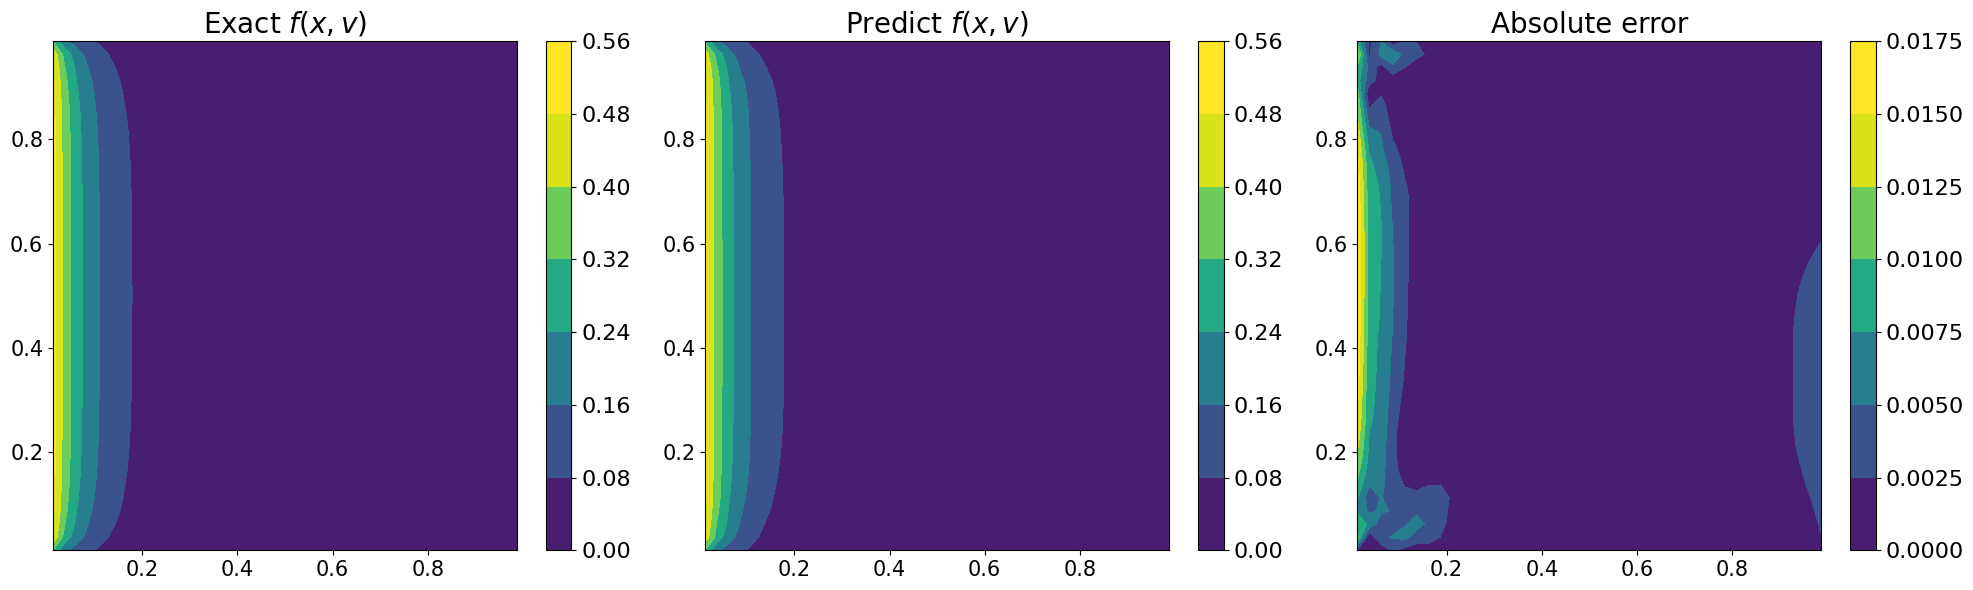

rmse: 0.028054424


In [20]:
# plot phi and absolute error
r = batch["position_coords"].reshape(*psi_shape[:-1], 2)
utils.plot_phi(r, ret["phi_label"], ret["phi_pre"])